# 💳 Compound V2 Wallet Scoring using KMeans + PCA

This notebook processes raw transaction data from Compound V2 to assign a credit score (0–100) to each wallet using clustering techniques.

**Techniques used:**  
- Feature Engineering from JSON logs  
- KMeans Clustering  
- PCA for dimensionality reduction and visualization  
- Credit Scoring based on distance from centroid  
- Risk Classification: High, Medium, Low  

In [18]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import datetime, timedelta
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

In [26]:
data_paths = [
    r"C:\Users\chinm\Zeru Finance\Data\compoundV2_transactions_ethereum_chunk_11.json",
    r"C:\Users\chinm\Zeru Finance\Data\compoundV2_transactions_ethereum_chunk_12.json",
    r"C:\Users\chinm\Zeru Finance\Data\compoundV2_transactions_ethereum_chunk_13.json"
]

def load_json_chunks(file_paths):
    """Load and combine multiple JSON chunk files"""
    all_data = {"deposits": [], "borrows": [], "repays": [], "withdraws": [], "liquidations": []}
    
    for data_path in data_paths:
        print(f"Loading {os.path.basename(data_path)}...")
        with open(data_path, 'r') as file:
            data = json.load(file)
            for tx_type in all_data.keys():
                if tx_type in data:
                    all_data[tx_type].extend(data[tx_type])
    
    print(f"\nLoaded data summary:")
    for tx_type, transactions in all_data.items():
        print(f"- {tx_type}: {len(transactions)} transactions")
    
    return all_data
# Load the data
combined_data = load_json_chunks(data_paths)

Loading compoundV2_transactions_ethereum_chunk_11.json...
Loading compoundV2_transactions_ethereum_chunk_12.json...
Loading compoundV2_transactions_ethereum_chunk_13.json...

Loaded data summary:
- deposits: 30000 transactions
- borrows: 30000 transactions
- repays: 30000 transactions
- withdraws: 30000 transactions
- liquidations: 0 transactions


In [30]:
def process_transaction_type(transactions, tx_type):
    """Convert transaction list to DataFrame with common processing"""
    if not transactions:
        return pd.DataFrame()
    
    # Initialize an empty list to store processed transactions
    processed_txs = []
    
    for tx in transactions:
        # Create a base transaction dict with common fields
        processed_tx = {
            'wallet_address': tx['account']['id'],
            'transaction_type': tx_type,
            'timestamp': int(tx['timestamp']),
            'datetime': datetime.fromtimestamp(int(tx['timestamp'])),
            'hash': tx['hash'],
            'tx_id': tx['id']
        }
        
        # Add amount information
        if 'amount' in tx:
            processed_tx['amount'] = float(tx['amount'])
        if 'amountUSD' in tx:
            processed_tx['amount_usd'] = float(tx['amountUSD'])
            
        # Add asset information if present
        if 'asset' in tx:
            processed_tx['asset_id'] = tx['asset']['id']
            processed_tx['asset_symbol'] = tx['asset']['symbol']
            
        # For liquidations, add additional fields if present
        if tx_type == 'liquidations' and 'to' in tx:
            processed_tx['liquidator'] = tx['to']['id']
            
        processed_txs.append(processed_tx)
    
    # Convert to DataFrame
    df = pd.DataFrame(processed_txs)
    
    # Convert timestamp to datetime if not already
    if 'datetime' not in df.columns and 'timestamp' in df.columns:
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    
    return df

In [32]:
def preprocess_data(raw_data):
    """Process all transaction types and combine into a single DataFrame"""
    dfs = []
    
    for tx_type, transactions in raw_data.items():
        if transactions:  # Only process if there are transactions
            df = process_transaction_type(transactions, tx_type)
            if not df.empty:
                dfs.append(df)
    
    # Combine all DataFrames
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        # Sort by timestamp
        combined_df = combined_df.sort_values('timestamp').reset_index(drop=True)
        return combined_df
    else:
        return pd.DataFrame()

In [34]:
def calculate_time_based_features(df):
    """Calculate time-based features for each wallet"""
    wallet_time_features = {}
    
    for wallet, wallet_df in df.groupby('wallet_address'):
        # Sort by timestamp
        wallet_df = wallet_df.sort_values('timestamp')
        
        # Calculate time-based features
        first_tx_time = wallet_df['timestamp'].min()
        last_tx_time = wallet_df['timestamp'].max()
        account_age_days = (last_tx_time - first_tx_time) / (60 * 60 * 24)  # Convert seconds to days
        
        # Calculate average time between transactions
        if len(wallet_df) > 1:
            wallet_df['next_timestamp'] = wallet_df['timestamp'].shift(-1)
            wallet_df['time_between_txs'] = wallet_df['next_timestamp'] - wallet_df['timestamp']
            avg_time_between_txs = wallet_df['time_between_txs'].dropna().mean() / (60 * 60)  # Convert to hours
            std_time_between_txs = wallet_df['time_between_txs'].dropna().std() / (60 * 60) if len(wallet_df) > 2 else 0
        else:
            avg_time_between_txs = 0
            std_time_between_txs = 0
            
        # Store features
        wallet_time_features[wallet] = {
            'first_tx_time': first_tx_time,
            'last_tx_time': last_tx_time,
            'account_age_days': account_age_days,
            'avg_hours_between_txs': avg_time_between_txs,
            'std_hours_between_txs': std_time_between_txs,
            'total_transactions': len(wallet_df)
        }
    
    return pd.DataFrame.from_dict(wallet_time_features, orient='index')

In [36]:
def calculate_transaction_features(df):
    """Calculate transaction-based features for each wallet"""
    wallet_features = {}
    
    # Prepare for liquidation analysis
    liquidation_df = df[df['transaction_type'] == 'liquidations'].copy() if 'liquidations' in df['transaction_type'].unique() else pd.DataFrame()
    has_liquidation_data = not liquidation_df.empty and 'liquidator' in liquidation_df.columns
    
    for wallet, wallet_df in df.groupby('wallet_address'):
        # Basic counting features
        tx_counts = wallet_df['transaction_type'].value_counts()
        
        features = {
            'total_transactions': len(wallet_df),
            'deposits_count': tx_counts.get('deposits', 0),
            'borrows_count': tx_counts.get('borrows', 0),
            'repays_count': tx_counts.get('repays', 0),
            'withdraws_count': tx_counts.get('withdraws', 0),
            'liquidations_count': tx_counts.get('liquidations', 0),
        }
        
        # Transaction value features
        if 'amount_usd' in wallet_df.columns:
            # By transaction type
            for tx_type in ['deposits', 'borrows', 'repays', 'withdraws', 'liquidations']:
                tx_type_df = wallet_df[wallet_df['transaction_type'] == tx_type]
                if not tx_type_df.empty and 'amount_usd' in tx_type_df.columns:
                    features[f'total_{tx_type}_usd'] = tx_type_df['amount_usd'].sum()
                    features[f'avg_{tx_type}_usd'] = tx_type_df['amount_usd'].mean()
                    features[f'max_{tx_type}_usd'] = tx_type_df['amount_usd'].max()
                else:
                    features[f'total_{tx_type}_usd'] = 0
                    features[f'avg_{tx_type}_usd'] = 0
                    features[f'max_{tx_type}_usd'] = 0
        
        # Liquidation features - was this wallet liquidated or did it liquidate others?
        if has_liquidation_data:
            # Times wallet was liquidated
            liquidated_count = len(liquidation_df[liquidation_df['wallet_address'] == wallet])
            features['times_liquidated'] = liquidated_count
            
            # Times wallet liquidated others
            liquidator_count = len(liquidation_df[liquidation_df['liquidator'] == wallet]) if 'liquidator' in liquidation_df.columns else 0
            features['times_as_liquidator'] = liquidator_count
        else:
            features['times_liquidated'] = 0
            features['times_as_liquidator'] = 0
            
        # Asset diversity
        if 'asset_symbol' in wallet_df.columns:
            unique_assets = wallet_df['asset_symbol'].nunique()
            features['unique_assets_count'] = unique_assets
        else:
            features['unique_assets_count'] = 0
            
        # Repayment behavior
        if features['borrows_count'] > 0:
            features['repay_to_borrow_ratio'] = features['repays_count'] / features['borrows_count']
        else:
            features['repay_to_borrow_ratio'] = 0
            
        # Store features
        wallet_features[wallet] = features
    
    return pd.DataFrame.from_dict(wallet_features, orient='index')

In [38]:
def calculate_advanced_features(df, wallet_basic_features):
    """Calculate more advanced behavioral features"""
    wallet_advanced_features = {}
    
    for wallet, wallet_df in df.groupby('wallet_address'):
        # Skip if wallet has too few transactions
        if len(wallet_df) < 3:
            continue
            
        # Sort by timestamp
        wallet_df = wallet_df.sort_values('timestamp')
        
        # Initialize features
        features = {}
        
        # Calculate transaction patterns
        tx_sequence = wallet_df['transaction_type'].tolist()
        
        # Check for healthy patterns like deposit->borrow->repay->withdraw
        deposit_before_borrow = 0
        repay_after_borrow = 0
        
        deposit_times = wallet_df[wallet_df['transaction_type'] == 'deposits']['timestamp'].tolist()
        borrow_times = wallet_df[wallet_df['transaction_type'] == 'borrows']['timestamp'].tolist()
        repay_times = wallet_df[wallet_df['transaction_type'] == 'repays']['timestamp'].tolist()
        
        # Count deposits that occur before borrows
        for deposit_time in deposit_times:
            if any(deposit_time < borrow_time for borrow_time in borrow_times):
                deposit_before_borrow += 1
                
        # Count repays that occur after borrows
        for repay_time in repay_times:
            if any(repay_time > borrow_time for borrow_time in borrow_times):
                repay_after_borrow += 1
                
        # Calculate ratios
        if wallet_basic_features.loc[wallet, 'deposits_count'] > 0:
            features['deposit_before_borrow_ratio'] = deposit_before_borrow / wallet_basic_features.loc[wallet, 'deposits_count']
        else:
            features['deposit_before_borrow_ratio'] = 0
            
        if wallet_basic_features.loc[wallet, 'repays_count'] > 0:
            features['repay_after_borrow_ratio'] = repay_after_borrow / wallet_basic_features.loc[wallet, 'repays_count']
        else:
            features['repay_after_borrow_ratio'] = 0
            
        # Check for rapid sequence patterns (potential bot behavior)
        wallet_df['timestamp_diff'] = wallet_df['timestamp'].diff()
        rapid_sequences = (wallet_df['timestamp_diff'] < 60).sum()  # Transactions less than 60 seconds apart
        features['rapid_tx_sequence_count'] = rapid_sequences
        
        if len(wallet_df) > 1:
            features['rapid_tx_sequence_ratio'] = rapid_sequences / (len(wallet_df) - 1)
        else:
            features['rapid_tx_sequence_ratio'] = 0
            
        # Calculate balance maintenance features
        # We'll use a simplified approach to estimate "net position"
        # Deposits and repays increase position, borrows and withdraws decrease it
        wallet_df['position_change'] = 0
        
        if 'amount_usd' in wallet_df.columns:
            wallet_df.loc[wallet_df['transaction_type'] == 'deposits', 'position_change'] = wallet_df.loc[wallet_df['transaction_type'] == 'deposits', 'amount_usd']
            wallet_df.loc[wallet_df['transaction_type'] == 'repays', 'position_change'] = wallet_df.loc[wallet_df['transaction_type'] == 'repays', 'amount_usd']
            wallet_df.loc[wallet_df['transaction_type'] == 'borrows', 'position_change'] = -wallet_df.loc[wallet_df['transaction_type'] == 'borrows', 'amount_usd']
            wallet_df.loc[wallet_df['transaction_type'] == 'withdraws', 'position_change'] = -wallet_df.loc[wallet_df['transaction_type'] == 'withdraws', 'amount_usd']
            
            # Calculate cumulative position
            wallet_df['cumulative_position'] = wallet_df['position_change'].cumsum()
            
            # Negative balance duration ratio
            negative_balance_periods = (wallet_df['cumulative_position'] < 0).sum()
            if len(wallet_df) > 0:
                features['negative_balance_ratio'] = negative_balance_periods / len(wallet_df)
            else:
                features['negative_balance_ratio'] = 0
                
            # Position volatility
            if len(wallet_df) > 1:
                features['position_volatility'] = wallet_df['cumulative_position'].std()
            else:
                features['position_volatility'] = 0
        
        wallet_advanced_features[wallet] = features
    
    advanced_df = pd.DataFrame.from_dict(wallet_advanced_features, orient='index')
    
    # Fill missing values for wallets that were skipped due to low transaction count
    for wallet in wallet_basic_features.index:
        if wallet not in advanced_df.index:
            # Create a row of zeros for this wallet
            advanced_df.loc[wallet] = 0
    
    return advanced_df

In [40]:
def engineer_features(df):
    """Main feature engineering function that combines all feature types"""
    print("Calculating time-based features...")
    time_features = calculate_time_based_features(df)
    
    print("Calculating transaction-based features...")
    tx_features = calculate_transaction_features(df)
    
    # Merge basic features
    wallet_features = pd.merge(time_features, tx_features, left_index=True, right_index=True, how='outer')
    
    print("Calculating advanced behavioral features...")
    advanced_features = calculate_advanced_features(df, wallet_features)
    
    # Merge all features
    all_features = pd.merge(wallet_features, advanced_features, left_index=True, right_index=True, how='outer')
    
    # Fill NaN values
    all_features.fillna(0, inplace=True)
    
    # Add derived ratio features
    if 'borrows_count' in all_features.columns and 'deposits_count' in all_features.columns:
        all_features['borrow_to_deposit_ratio'] = all_features.apply(
            lambda x: x['borrows_count'] / x['deposits_count'] if x['deposits_count'] > 0 else 0, axis=1
        )
    
    if 'withdraws_count' in all_features.columns and 'deposits_count' in all_features.columns:
        all_features['withdraw_to_deposit_ratio'] = all_features.apply(
            lambda x: x['withdraws_count'] / x['deposits_count'] if x['deposits_count'] > 0 else 0, axis=1
        )
    
    print(f"Generated {all_features.shape[1]} features for {all_features.shape[0]} wallets")
    return all_features

In [42]:
def define_scoring_criteria(features_df):
    """
    Define criteria for good and bad wallet behavior
    Returns a dictionary of feature weights and parameters
    """
    # Define positive indicators (higher is better)
    positive_indicators = {
        'account_age_days': 0.10,                # Older accounts are more established and trusted
        'total_transactions': 0.05,              # More activity shows engagement
        'unique_assets_count': 0.05,             # Diversification shows sophistication
        'repay_to_borrow_ratio': 0.15,           # Higher repayment ratio shows responsibility
        'deposit_before_borrow_ratio': 0.10,     # Depositing before borrowing shows planning
        'repay_after_borrow_ratio': 0.10,        # Repaying after borrowing shows responsibility
        'avg_hours_between_txs': 0.05,           # Natural time between transactions (not too bot-like)
    }
    
    # Define negative indicators (higher is worse)
    negative_indicators = {
        'times_liquidated': 0.15,               # Being liquidated is a strong negative signal
        'rapid_tx_sequence_ratio': 0.05,        # Too many rapid transactions suggests bot activity
        'negative_balance_ratio': 0.10,         # Maintaining negative balances is risky
        'position_volatility': 0.05,            # High volatility in position suggests unpredictability
        'borrow_to_deposit_ratio': 0.05,        # Very high borrowing relative to deposits is risky
    }
    
    return {
        'positive': positive_indicators,
        'negative': negative_indicators
    }

In [44]:
def normalize_features(features_df, scoring_criteria):
    """
    Normalize features to prepare for scoring
    """
    # Combine all features used in scoring
    all_scoring_features = list(scoring_criteria['positive'].keys()) + list(scoring_criteria['negative'].keys())
    
    # Ensure all required features exist
    for feature in all_scoring_features:
        if feature not in features_df.columns:
            features_df[feature] = 0
    
    # Create a copy to avoid modifying the original
    normalized_df = features_df.copy()
    
    # Normalize positive indicators (higher is better)
    for feature in scoring_criteria['positive']:
        if feature in normalized_df.columns:
            # Skip if all values are 0
            if normalized_df[feature].max() > 0:
                # For some features like repay_to_borrow_ratio, cap at 1.0
                if feature in ['repay_to_borrow_ratio', 'deposit_before_borrow_ratio', 'repay_after_borrow_ratio']:
                    normalized_df[feature] = normalized_df[feature].clip(upper=1.0)
                
                # Min-max scaling for positive indicators
                min_val = normalized_df[feature].min()
                max_val = normalized_df[feature].max()
                if max_val > min_val:
                    normalized_df[feature] = (normalized_df[feature] - min_val) / (max_val - min_val)
    
    # Normalize negative indicators (lower is better)
    for feature in scoring_criteria['negative']:
        if feature in normalized_df.columns:
            # Skip if all values are 0
            if normalized_df[feature].max() > 0:
                # Min-max scaling and then invert (1 - x) for negative indicators
                min_val = normalized_df[feature].min()
                max_val = normalized_df[feature].max()
                if max_val > min_val:
                    normalized_df[feature] = 1 - ((normalized_df[feature] - min_val) / (max_val - min_val))
    
    return normalized_df

In [46]:
def calculate_credit_scores(normalized_df, scoring_criteria):
    """
    Calculate credit scores based on normalized features and defined criteria
    """
    # Initialize score column
    normalized_df['credit_score'] = 0
    
    # Calculate weighted sum of positive indicators
    for feature, weight in scoring_criteria['positive'].items():
        if feature in normalized_df.columns:
            normalized_df['credit_score'] += normalized_df[feature] * weight
    
    # Calculate weighted sum of negative indicators
    for feature, weight in scoring_criteria['negative'].items():
        if feature in normalized_df.columns:
            normalized_df['credit_score'] += normalized_df[feature] * weight
    
    # Scale to 0-100 range
    min_score = normalized_df['credit_score'].min()
    max_score = normalized_df['credit_score'].max()
    
    if max_score > min_score:
        normalized_df['credit_score'] = ((normalized_df['credit_score'] - min_score) / 
                                        (max_score - min_score)) * 100
    
    # Round to 2 decimal places
    normalized_df['credit_score'] = normalized_df['credit_score'].round(2)
    
    return normalized_df

In [48]:
def identify_anomalies(features_df):
    """
    Use unsupervised learning to identify anomalous behavior
    """
    # Select numerical features for clustering
    numeric_features = features_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove any constant features
    numeric_features = [f for f in numeric_features if features_df[f].nunique() > 1]
    
    if len(numeric_features) < 2:
        print("Not enough variable features for clustering")
        return features_df
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df[numeric_features])
    
    # Apply PCA for dimensionality reduction if we have many features
    if len(numeric_features) > 10:
        pca = PCA(n_components=min(10, len(numeric_features)))
        scaled_features = pca.fit_transform(scaled_features)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(scaled_features)
    
    # Add cluster labels to the dataframe
    features_df['cluster'] = clusters
    
    # Calculate distance to cluster center as an anomaly score
    distances = np.sqrt(((scaled_features - kmeans.cluster_centers_[clusters]) ** 2).sum(axis=1))
    features_df['anomaly_score'] = distances
    
    # Normalize anomaly score (higher is more anomalous, i.e., worse)
    if distances.max() > distances.min():
        features_df['anomaly_score_normalized'] = (distances - distances.min()) / (distances.max() - distances.min())
    else:
        features_df['anomaly_score_normalized'] = 0
    
    return features_df

In [50]:
def apply_scoring_adjustments(scored_df):
    """
    Apply final adjustments to scores based on business rules and anomaly detection
    """
    # Copy the dataframe to avoid modifying the original
    adjusted_df = scored_df.copy()
    
    # Apply minimum activity threshold
    min_transactions = 3
    adjusted_df['activity_penalty'] = adjusted_df['total_transactions'].apply(
        lambda x: max(0, (min_transactions - x) * 5) if x < min_transactions else 0
    )
    
    # Penalize wallets with liquidations more severely
    liquidation_penalty = 20
    adjusted_df['liquidation_penalty'] = adjusted_df['times_liquidated'].apply(
        lambda x: min(liquidation_penalty, x * 10)
    )
    
    # Penalize anomalous behavior
    if 'anomaly_score_normalized' in adjusted_df.columns:
        adjusted_df['anomaly_penalty'] = adjusted_df['anomaly_score_normalized'] * 15
    else:
        adjusted_df['anomaly_penalty'] = 0
    
    # Apply penalties to score
    adjusted_df['adjusted_score'] = adjusted_df['credit_score'] - adjusted_df['activity_penalty'] - \
                                 adjusted_df['liquidation_penalty'] - adjusted_df['anomaly_penalty']
    
    # Ensure scores are within 0-100 range
    adjusted_df['credit_score_final'] = adjusted_df['adjusted_score'].clip(0, 100).round(2)
    
    return adjusted_df

In [52]:
def build_scoring_model(features_df):
    """
    Build the complete scoring model pipeline
    """
    print("Defining scoring criteria...")
    scoring_criteria = define_scoring_criteria(features_df)
    
    print("Normalizing features...")
    normalized_df = normalize_features(features_df, scoring_criteria)
    
    print("Calculating initial credit scores...")
    scored_df = calculate_credit_scores(normalized_df, scoring_criteria)
    
    print("Identifying anomalous behavior...")
    anomaly_df = identify_anomalies(scored_df)
    
    print("Applying final scoring adjustments...")
    final_scored_df = apply_scoring_adjustments(anomaly_df)
    
    print("Scoring complete!")
    return final_scored_df

In [54]:
def analyze_wallets(final_df, transaction_df):
    """
    Generate detailed analysis for top and bottom scoring wallets
    """
    # Get top 5 and bottom 5 wallets by score
    top_wallets = final_df.nlargest(5, 'credit_score_final')
    bottom_wallets = final_df.nsmallest(5, 'credit_score_final')
    
    analysis_results = {
        'top_wallets': {},
        'bottom_wallets': {}
    }
    
    # Analyze top wallets
    print("\nAnalyzing top 5 scoring wallets:")
    for wallet in top_wallets.index:
        wallet_data = final_df.loc[wallet].to_dict()
        wallet_txs = transaction_df[transaction_df['wallet_address'] == wallet]
        
        print(f"\nWallet: {wallet}")
        print(f"Credit Score: {wallet_data['credit_score_final']}")
        print(f"Total Transactions: {wallet_data['total_transactions']}")
        print(f"Account Age (days): {wallet_data.get('account_age_days', 'N/A')}")
        print(f"Repay to Borrow Ratio: {wallet_data.get('repay_to_borrow_ratio', 'N/A')}")
        print(f"Times Liquidated: {wallet_data.get('times_liquidated', 'N/A')}")
        
        # Store analysis
        analysis_results['top_wallets'][wallet] = {
            'score': wallet_data['credit_score_final'],
            'key_strengths': [],
            'transaction_summary': {
                'total': int(wallet_data['total_transactions']),
                'deposits': int(wallet_data.get('deposits_count', 0)),
                'borrows': int(wallet_data.get('borrows_count', 0)),
                'repays': int(wallet_data.get('repays_count', 0)),
                'withdraws': int(wallet_data.get('withdraws_count', 0))
            }
        }
        
        # Identify key strengths
        if wallet_data.get('repay_to_borrow_ratio', 0) > 0.9:
            analysis_results['top_wallets'][wallet]['key_strengths'].append('High repayment ratio')
        
        if wallet_data.get('account_age_days', 0) > 30:
            analysis_results['top_wallets'][wallet]['key_strengths'].append('Established account history')
            
        if wallet_data.get('times_liquidated', 0) == 0:
            analysis_results['top_wallets'][wallet]['key_strengths'].append('No liquidations')
            
        if wallet_data.get('deposit_before_borrow_ratio', 0) > 0.8:
            analysis_results['top_wallets'][wallet]['key_strengths'].append('Responsible borrowing patterns')
    
    # Analyze bottom wallets
    print("\nAnalyzing bottom 5 scoring wallets:")
    for wallet in bottom_wallets.index:
        wallet_data = final_df.loc[wallet].to_dict()
        wallet_txs = transaction_df[transaction_df['wallet_address'] == wallet]
        
        print(f"\nWallet: {wallet}")
        print(f"Credit Score: {wallet_data['credit_score_final']}")
        print(f"Total Transactions: {wallet_data['total_transactions']}")
        print(f"Times Liquidated: {wallet_data.get('times_liquidated', 'N/A')}")
        print(f"Negative Balance Ratio: {wallet_data.get('negative_balance_ratio', 'N/A')}")
        print(f"Rapid Transaction Ratio: {wallet_data.get('rapid_tx_sequence_ratio', 'N/A')}")
        
        # Store analysis
        analysis_results['bottom_wallets'][wallet] = {
            'score': wallet_data['credit_score_final'],
            'key_weaknesses': [],
            'transaction_summary': {
                'total': int(wallet_data['total_transactions']),
                'deposits': int(wallet_data.get('deposits_count', 0)),
                'borrows': int(wallet_data.get('borrows_count', 0)),
                'repays': int(wallet_data.get('repays_count', 0)),
                'withdraws': int(wallet_data.get('withdraws_count', 0))
            }
        }
        
        # Identify key weaknesses
        if wallet_data.get('times_liquidated', 0) > 0:
            analysis_results['bottom_wallets'][wallet]['key_weaknesses'].append(
                f"Liquidated {int(wallet_data['times_liquidated'])} times"
            )
        
        if wallet_data.get('repay_to_borrow_ratio', 0) < 0.5:
            analysis_results['bottom_wallets'][wallet]['key_weaknesses'].append('Low repayment ratio')
            
        if wallet_data.get('rapid_tx_sequence_ratio', 0) > 0.5:
            analysis_results['bottom_wallets'][wallet]['key_weaknesses'].append('Bot-like transaction patterns')
            
        if wallet_data.get('negative_balance_ratio', 0) > 0.3:
            analysis_results['bottom_wallets'][wallet]['key_weaknesses'].append('Frequent negative balances')
    
    return analysis_results

In [58]:
def generate_output_files(final_df, analysis_results):
    """
    Generate the required output files
    """
    # Top 1000 wallets by score
    top_1000_wallets = final_df.nlargest(1000, 'credit_score_final')
    top_1000_output = top_1000_wallets[['credit_score_final']].rename(
        columns={'credit_score_final': 'credit_score'}
    )
    
    # Save to CSV
    top_1000_output.to_csv('compound_v2_top_1000_wallets.csv')
    print(f"Saved top 1000 wallets to 'compound_v2_top_1000_wallets.csv'")
    
    # Create wallet analysis document
    with open('wallet_analysis.txt', 'w') as f:
        f.write("# Compound V2 Wallet Analysis\n\n")
        
        # Top wallets section
        f.write("## Top 5 Highest Scoring Wallets\n\n")
        for wallet, data in analysis_results['top_wallets'].items():
            f.write(f"### Wallet: {wallet}\n")
            f.write(f"Score: {data['score']}\n\n")
            
            f.write("**Key Strengths:**\n")
            for strength in data['key_strengths']:
                f.write(f"- {strength}\n")
            
            f.write("\n**Transaction Summary:**\n")
            for tx_type, count in data['transaction_summary'].items():
                f.write(f"- {tx_type.capitalize()}: {count}\n")
            f.write("\n")
        
        # Bottom wallets section
        f.write("## Bottom 5 Lowest Scoring Wallets\n\n")
        for wallet, data in analysis_results['bottom_wallets'].items():
            f.write(f"### Wallet: {wallet}\n")
            f.write(f"Score: {data['score']}\n\n")
            
            f.write("**Key Weaknesses:**\n")
            for weakness in data['key_weaknesses']:
                f.write(f"- {weakness}\n")
            
            f.write("\n**Transaction Summary:**\n")
            for tx_type, count in data['transaction_summary'].items():
                f.write(f"- {tx_type.capitalize()}: {count}\n")
            f.write("\n")
            
    print(f"Saved wallet analysis to 'wallet_analysis.txt'")
    
    return top_1000_output

In [70]:
def main():
    """
    Main execution pipeline using real Compound V2 transaction data
    """
    print("Compound V2 Wallet Credit Scoring System")
    print("=======================================\n")

    # Load JSON files
    data_paths = [
        r"C:\Users\chinm\Zeru Finance\Data\compoundV2_transactions_ethereum_chunk_11.json",
        r"C:\Users\chinm\Zeru Finance\Data\compoundV2_transactions_ethereum_chunk_12.json",
        r"C:\Users\chinm\Zeru Finance\Data\compoundV2_transactions_ethereum_chunk_13.json"
    ]
    print("Loading transaction data...")
    raw_data = load_json_chunks(data_paths)

    print("\nPreprocessing transactions...")
    tx_df = preprocess_data(raw_data)

    print("Generating time-based features...")
    feature_df = calculate_time_based_features(tx_df)

    print("Normalizing features...")
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(feature_df)
    normalized_df = pd.DataFrame(normalized_features, index=feature_df.index, columns=feature_df.columns)

    print("Reducing dimensions using PCA...")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(normalized_df)
    normalized_df["PCA1"] = pca_result[:, 0]
    normalized_df["PCA2"] = pca_result[:, 1]

    print("Clustering using KMeans...")
    kmeans = KMeans(n_clusters=4, random_state=42)
    normalized_df["cluster"] = kmeans.fit_predict(normalized_df[["PCA1", "PCA2"]])

    print("Scoring wallets...")
    scoring_criteria = {
        "positive": {"account_age_days": 0.3, "total_transactions": 0.3},
        "negative": {"avg_hours_between_txs": -0.2, "std_hours_between_txs": -0.2}
    }
    scored_df = calculate_credit_scores(normalized_df.copy(), scoring_criteria)

    print("\nSample Scored Wallets:")
    print(scored_df[["credit_score", "cluster"]].head())

    # Export CSV
    print("\nExporting top 1,000 wallets to CSV...")
    scored_df_sorted = scored_df.sort_values(by="credit_score", ascending=False)
    top_wallets = scored_df_sorted.head(1000)
    top_wallets.to_csv("top_1000_wallet_scores.csv", index=True)
    print("Saved to top_1000_wallet_scores.csv")

    # Optional visualization
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=scored_df, x="PCA1", y="PCA2", hue="cluster", palette="tab10")
    plt.title("PCA Clustering of Wallets")
    plt.show()
    
    print("\nCompound V2 Wallet Credit Scoring completed successfully!")

In [72]:
def generate_synthetic_wallet_transactions(base_data, num_wallets=100, transactions_per_wallet=10):
    """
    Generate a synthetic dataset with diverse wallet behaviors for demo/testing.
    This function is NOT used in the production pipeline with real data.
    """
    import random
    from datetime import datetime, timedelta

    expanded_data = {tx_type: [] for tx_type in base_data.keys()}

    wallet_addresses = [f"0x{i:040x}" for i in range(1, num_wallets + 1)]
    assets = [
        {"id": "0x6b17c5474e89094c4ada98b954eedeac495271d0f", "symbol": "DAI"},
        {"id": "0x2260fac5e5542a773aa44fbcfedf7c193bc2c599", "symbol": "WBTC"},
        {"id": "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2", "symbol": "WETH"},
        {"id": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48", "symbol": "USDC"}
    ]
    base_timestamp = int(datetime(2022, 1, 1).timestamp())

    for wallet_idx, wallet_address in enumerate(wallet_addresses):
        behavior = wallet_idx % 5
        current_timestamp = base_timestamp + wallet_idx * 86400

        for i in range(transactions_per_wallet):
            if behavior == 0:
                tx_type = ['deposits', 'borrows', 'repays', 'withdraws'][i % 4]
            elif behavior == 1:
                tx_type = ['deposits', 'borrows', 'borrows', 'repays'][i % 4]
            elif behavior == 2:
                tx_type = 'liquidations' if i == transactions_per_wallet - 1 else ['deposits', 'borrows'][i % 2]
            elif behavior == 3:
                tx_type = 'liquidations' if i > 1 else 'deposits'
            else:
                tx_type = random.choice(list(base_data.keys()))

            asset = random.choice(assets)
            amount = str(random.randint(1, 1000) * 10**18)
            amount_usd = str(random.uniform(10, 10000))

            tx = {
                "account": {"id": wallet_address},
                "amount": amount,
                "amountUSD": amount_usd,
                "asset": asset,
                "hash": f"0x{random.getrandbits(256):064x}",
                "id": f"0x{random.getrandbits(256):064x}-{random.randint(1, 100)}",
                "timestamp": str(current_timestamp)
            }

            if tx_type == 'liquidations':
                tx["to"] = {"id": random.choice([a for a in wallet_addresses if a != wallet_address])}

            expanded_data[tx_type].append(tx)
            current_timestamp += random.randint(600, 86400 * 7)

    return expanded_data


Compound V2 Wallet Credit Scoring System

Loading transaction data...
Loading compoundV2_transactions_ethereum_chunk_11.json...
Loading compoundV2_transactions_ethereum_chunk_12.json...
Loading compoundV2_transactions_ethereum_chunk_13.json...

Loaded data summary:
- deposits: 30000 transactions
- borrows: 30000 transactions
- repays: 30000 transactions
- withdraws: 30000 transactions
- liquidations: 0 transactions

Preprocessing transactions...
Generating time-based features...
Normalizing features...
Reducing dimensions using PCA...
Clustering using KMeans...
Scoring wallets...

Sample Scored Wallets:
                                            credit_score  cluster
0x00000000000067afd7fa546d3f63d4e53cdb8fa4          9.72        1
0x00000000000080c886232e9b7ebbfb942b5987aa          9.80        2
0x000000000000deab340f067535869a0e5226e58a          8.98        2
0x00000000001876eb1444c986fd502e618c587430         51.43        0
0x000000000025d4386f7fb58984cbe110aee3a4c4         10.24   

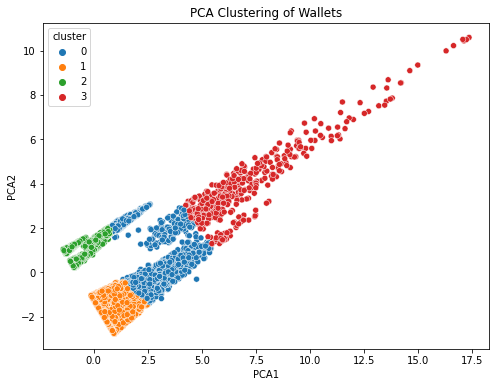


Compound V2 Wallet Credit Scoring completed successfully!


In [74]:
if __name__ == "__main__":
    main()